<a href="https://colab.research.google.com/github/ali3brt/-Ali3brt-s-Machine-Learning-and-Deep-Learning-Projects/blob/main/02_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.3 MB/s eta 0:00:00


**The primary reason LoRA (Low-Rank Adaptation) is used in this context is to make it feasible to run the fine-tuning or adapted model on resource-constrained environments, such as Google Colab (or other setups with limited GPU memory).**

In [2]:
import mediapy as media
import random
import sys
import torch

from diffusers import DiffusionPipeline, TCDScheduler
from huggingface_hub import hf_hub_download

# Choose either 8 or 12 steps for the diffusion process:
# This affects the tradeoff between generation speed and image quality.
num_inference_steps = 12

# Base model: Stable Diffusion XL (SDXL), a high-capacity image synthesis model.
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"

# Hugging Face repository containing LoRA weights for the model.
repo_name = "ByteDance/Hyper-SD"

# Adjust checkpoint name based on the number of inference steps.
plural = "s" if num_inference_steps > 1 else ""
ckpt_name = f"Hyper-SDXL-{num_inference_steps}step{plural}-CFG-lora.safetensors"

# Use GPU for computation if available (CUDA).
device = "cuda"

# Initialize the Stable Diffusion pipeline with the base model.
# - torch_dtype=torch.float16: Use 16-bit precision for faster computation and reduced memory usage.
# - variant="fp16": Ensures compatibility with 16-bit precision.
pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16, variant="fp16").to(device)

# Download the LoRA (Low-Rank Adaptation) checkpoint from the Hugging Face Hub.
# LoRA is a method for fine-tuning large models efficiently:
# - Instead of retraining all model parameters, LoRA updates only a small subset of parameters
#   (low-rank matrices added to certain layers). This reduces computational cost and memory usage.
# - LoRA allows a base model to be quickly adapted to specific tasks or styles.
pipe.load_lora_weights(hf_hub_download(repo_name, ckpt_name))

# Fuse the LoRA weights into the model, making it ready for inference.
pipe.fuse_lora()

# Replace the default scheduler with TCDScheduler, which guides the diffusion process.
# Schedulers determine how the generated image is refined step-by-step.
pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Hyper-SDXL-12steps-CFG-lora.safetensors:   0%|          | 0.00/787M [00:00<?, ?B/s]

The config attributes {'skip_prk_steps': True} were passed to TCDScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/12 [00:00<?, ?it/s]

Prompt:	frog in hut raining outside
Seed:	1426964464482302553


""

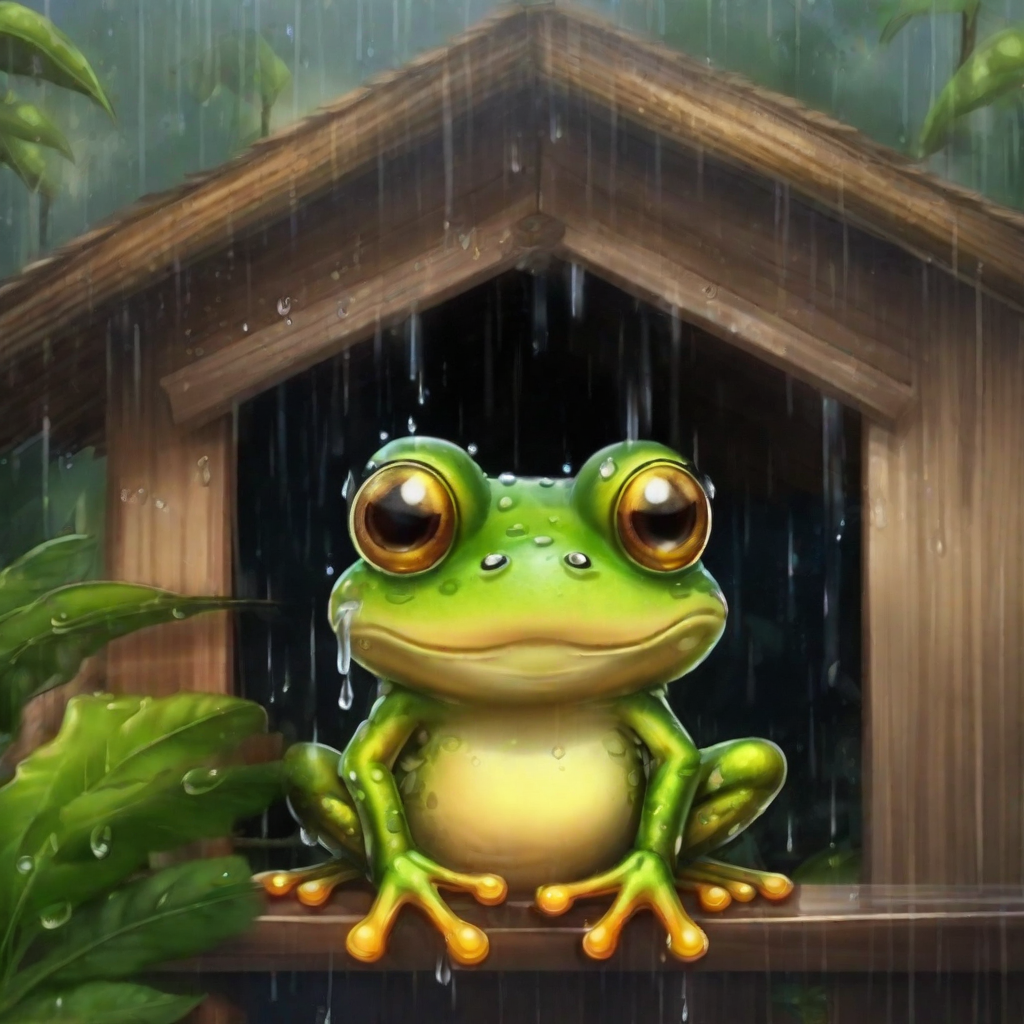

In [3]:
prompt = "frog in hut raining outside"
seed = random.randint(0, sys.maxsize)

# Pick a value between 5.0 and 8.0:
guidance_scale = 5.0

# Decrease eta (min: 0, max: 1.0) to get more details with multi-step inference:
eta = 0.5

images = pipe(
    prompt = prompt,
    num_inference_steps = num_inference_steps,
    guidance_scale = guidance_scale,
    eta = eta,
    generator = torch.Generator(device).manual_seed(seed),
    ).images

print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)
images[0].save("output.jpg")